In [3]:
import os
import h5py
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import f1_score
from pathlib import Path
import matplotlib.pyplot as plt



In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
# ------------------------
# 1️⃣ Custom Dataset Class
# ------------------------
class VibrationDataset(Dataset):
    def __init__(self, data_dir):
        self.file_paths = []
        self.labels = []

        for label, label_idx in zip(["good", "bad"], [0, 1]):  # 0=good, 1=bad
            folder = Path(data_dir) / label
            for file_name in os.listdir(folder):
                if file_name.endswith(".h5"):
                    self.file_paths.append(os.path.join(folder, file_name))
                    self.labels.append(label_idx)

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        file_path = self.file_paths[idx]
        with h5py.File(file_path, "r") as f:
            data = f["vibration_data"][:]  # Shape (10000, 3)

        data = np.transpose(data, (1, 0))  # Change to (3, 10000) for CNN
        label = self.labels[idx]

        return torch.tensor(data, dtype=torch.float32), torch.tensor(label, dtype=torch.long)


In [6]:
# ------------------------
# 2️⃣ Define the CNN Model
# ------------------------
class CNN1D(nn.Module):
    def __init__(self):
        super(CNN1D, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=3, out_channels=16, kernel_size=7, stride=1, padding=3)
        self.bn1 = nn.BatchNorm1d(16)
        self.pool1 = nn.MaxPool1d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=2)
        self.bn2 = nn.BatchNorm1d(32)
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm1d(64)
        self.pool3 = nn.MaxPool1d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(64 * 1250, 256)  # Flattened size: (64, 1250)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 2)  # Binary classification (good/bad)

        self.dropout = nn.Dropout(0.3)  # Reduce overfitting
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool1(self.relu(self.bn1(self.conv1(x))))
        x = self.pool2(self.relu(self.bn2(self.conv2(x))))
        x = self.pool3(self.relu(self.bn3(self.conv3(x))))

        x = x.view(x.shape[0], -1)  # Flatten
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.fc3(x)  # No activation (we use CrossEntropyLoss)

        return x


In [7]:
# ------------------------
# 5️⃣ Full Training Pipeline
# ------------------------
def train_and_evaluate(data_dir, batch_size=32, epochs=20, lr=0.001, train_ratio=0.7, val_ratio=0.15):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Load dataset and split into train, val, test sets
    dataset = VibrationDataset(data_dir)
    train_size = int(train_ratio * len(dataset))
    val_size = int(val_ratio * len(dataset))
    test_size = len(dataset) - train_size - val_size
    train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Model setup
    model = CNN1D().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Training and validation loop
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(epochs):
        train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, device)
        val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        print(f"Epoch [{epoch+1}/{epochs}] - "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} - "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    print("✅ Training and validation complete!")

    # Evaluate on the test set
    f1, accuracy = test_model(model, test_loader, device)
    print(f"🔥 Test F1 Score: {f1:.4f}, Test Accuracy: {accuracy:.4f}")

    return model

In [8]:
# ------------------------
# 3️⃣ Train & Evaluate Functions
# ------------------------
def train_epoch(model, train_loader, optimizer, criterion, device):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    accuracy = correct / total
    return total_loss / len(train_loader), accuracy


In [9]:
def validate_epoch(model, val_loader, criterion, device):
    model.eval()
    total_loss, correct, total = 0, 0, 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total
    return total_loss / len(val_loader), accuracy

In [10]:
# ------------------------
# 4️⃣ Test the Model
# ------------------------
def test_model(model, test_loader, device):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1)  # Get predicted class

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute F1-score
    f1 = f1_score(all_labels, all_preds, average="weighted")
    accuracy = (np.array(all_preds) == np.array(all_labels)).mean()

    return f1, accuracy


In [11]:
# Splitting the dataset
data_directory = "./data/final/Selected_data_windowed_grouped_normalized"

dataset = VibrationDataset(data_directory)
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Creating DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [12]:
# ------------------------
# 5️⃣ Full Training Pipeline
# ------------------------
def train_and_evaluate(train_loader, val_loader, test_loader, epochs=20, lr=0.001):

    '''
        # Load dataset and split into train, val, test sets
    dataset = VibrationDataset(data_dir)
    train_size = int(train_ratio * len(dataset))
    val_size = int(val_ratio * len(dataset))
    test_size = len(dataset) - train_size - val_size
    train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    '''

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Model setup
    model = CNN1D().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Training and validation loop
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(epochs):
        train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, device)
        val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        print(f"Epoch [{epoch+1}/{epochs}] - "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} - "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    print("✅ Training and validation complete!")

    # Evaluate on the test set
    f1, accuracy = test_model(model, test_loader, device)
    print(f"🔥 Test F1 Score: {f1:.4f}, Test Accuracy: {accuracy:.4f}")

    return model

In [13]:
# ------------------------
# 6️⃣ Run Training & Evaluation
# ------------------------
model = train_and_evaluate(train_loader, val_loader, test_loader)


Epoch [1/20] - Train Loss: 1.7353, Train Acc: 0.7250 - Val Loss: 0.5065, Val Acc: 0.8350
Epoch [2/20] - Train Loss: 0.6269, Train Acc: 0.8500 - Val Loss: 0.1764, Val Acc: 0.9417
Epoch [3/20] - Train Loss: 0.2915, Train Acc: 0.8979 - Val Loss: 0.1199, Val Acc: 0.9515
Epoch [4/20] - Train Loss: 0.1609, Train Acc: 0.9375 - Val Loss: 0.1357, Val Acc: 0.9612
Epoch [5/20] - Train Loss: 0.0447, Train Acc: 0.9833 - Val Loss: 0.0470, Val Acc: 0.9806
Epoch [6/20] - Train Loss: 0.0491, Train Acc: 0.9854 - Val Loss: 0.0592, Val Acc: 0.9709
Epoch [7/20] - Train Loss: 0.0283, Train Acc: 0.9854 - Val Loss: 0.0459, Val Acc: 0.9709
Epoch [8/20] - Train Loss: 0.0422, Train Acc: 0.9833 - Val Loss: 0.0933, Val Acc: 0.9612
Epoch [9/20] - Train Loss: 0.0208, Train Acc: 0.9958 - Val Loss: 0.0671, Val Acc: 0.9806
Epoch [10/20] - Train Loss: 0.0144, Train Acc: 0.9938 - Val Loss: 0.1191, Val Acc: 0.9612
Epoch [11/20] - Train Loss: 0.0110, Train Acc: 0.9958 - Val Loss: 0.0395, Val Acc: 0.9806
Epoch [12/20] - Tra

In [14]:
# Save the trained model
torch.save(model.state_dict(), "cnn1d_model.pth")
print("✅ Model saved to cnn1d_model.pth")


✅ Model saved to cnn1d_model.pth


In [15]:

model.eval()  # Switch to evaluation mode
print("✅ Model loaded and ready for explanations")


✅ Model loaded and ready for explanations


In [16]:
# ------------------------
# 7️⃣ Explain with Gradients

def explain_with_gradients_time_domain(model, sample, label, device="cuda"):
    model.eval()
    sample = sample.unsqueeze(0).to(device)  # Add batch dimension and move to GPU
    sample.requires_grad = True  # Enable gradient computation

    label_tensor = torch.tensor([label], device=device)  # Ensure label is on the same device
    output = model(sample)
    loss = torch.nn.functional.cross_entropy(output, label_tensor)
    loss.backward()

    gradients = sample.grad.cpu().detach().numpy()[0]  # Shape: (3, 10000)
    return gradients




In [17]:
# ------------------------
# 8️⃣ Explain with smoothgrad

def smoothgrad_time_domain(model, sample, label, num_samples=50, noise_level=0.1, device="cuda"):
    model.eval()
    sample = sample.unsqueeze(0).to(device)  # Add batch dimension
    sample.requires_grad = True  # Enable gradient computation

    total_gradients = torch.zeros_like(sample).to(device)

    for _ in range(num_samples):
        noise = torch.normal(mean=0, std=noise_level, size=sample.shape).to(device)
        noisy_sample = sample + noise

        output = model(noisy_sample)
        loss = torch.nn.functional.cross_entropy(output, torch.tensor([label], device=device))
        loss.backward()
        total_gradients += sample.grad

    avg_gradients = total_gradients / num_samples
    return avg_gradients.cpu().detach().numpy()[0]  # Shape: (3, 10000)




In [18]:
# ------------------------
# 9️⃣ Explain with Integrated Gradients
def integrated_gradients_time_domain(model, sample, label, steps=50, device="cuda"):
    model.eval()
    sample = sample.unsqueeze(0).to(device)
    sample.requires_grad = True

    baseline = torch.zeros_like(sample).to(device)  # Zero baseline
    scaled_inputs = [baseline + (float(i) / steps) * (sample - baseline) for i in range(steps)]
    scaled_inputs = torch.stack(scaled_inputs).to(device)

    total_gradients = torch.zeros_like(sample).to(device)

    for inp in scaled_inputs:
        output = model(inp)
        loss = torch.nn.functional.cross_entropy(output, torch.tensor([label], device=device))
        loss.backward()
        total_gradients += sample.grad

    avg_gradients = total_gradients / steps
    return avg_gradients.cpu().detach().numpy()[0]  # Shape: (3, 10000)




In [19]:
# ------------------------
# 10️⃣ Explain with Occlusion

def occlusion_sensitivity_time_domain(model, sample, label, window_size=100, device="cuda"):
    model.eval()
    sample = sample.unsqueeze(0).to(device)

    original_output = model(sample)
    original_pred = torch.argmax(original_output, dim=1).item()

    occlusion_importance = np.zeros_like(sample.cpu().numpy())

    for i in range(0, sample.shape[2] - window_size, window_size // 2):
        occluded_sample = sample.clone()
        occluded_sample[:, :, i:i+window_size] = 0  # Zero out part of the input

        output = model(occluded_sample)
        new_pred = torch.argmax(output, dim=1).item()

        if new_pred != original_pred:
            occlusion_importance[:, :, i:i+window_size] += 1

    return occlusion_importance[0]  # Shape: (3, 10000)




In [20]:
def xai_occlusion_signal(model, signal, label, occlusion_type="zero", device="cuda"):
    """
    Compute relevance using occlusion for signal data with multiple occlusion types.
    Args:
        model: The trained CNN model.
        signal: Input signal (3, 10000) for one sample.
        label: True label for the signal (0 or 1).
        occlusion_type: Type of occlusion ("zero", "one", "mone", "flip").
        device: Device to run computations ("cuda" or "cpu").
    Returns:
        attribution: Attribution array (3, 10000).
    """
    # Define occlusion operations
    def zero(_): return 0
    def one(_): return 1
    def mone(_): return -1
    def flip(val): return -val

    occlusion_fxns = {"zero": zero, "one": one, "mone": mone, "flip": flip}

    # Ensure the occlusion function is valid
    assert occlusion_type in occlusion_fxns, f"Invalid occlusion type: {occlusion_type}"

    # Save original signal and model prediction
    signal = signal.unsqueeze(0).to(device)  # Add batch dimension
    signal.requires_grad = False
    pred_original = model(signal)
    original_score = pred_original[0, label].item()

    # Prepare attribution array
    attributions = torch.zeros_like(signal).squeeze(0)  # Shape: (3, 10000)

    # Iterate through each feature (X, Y, Z axes) and time step
    for feature_idx in range(signal.shape[1]):  # Iterate over axes (X, Y, Z)
        for time_idx in range(signal.shape[2]):  # Iterate over time steps
            # Create a copy of the signal
            occluded_signal = signal.clone()

            # Apply the occlusion function
            occluded_signal[0, feature_idx, time_idx] = occlusion_fxns[occlusion_type](
                signal[0, feature_idx, time_idx].item()
            )

            # Get prediction for the occluded signal
            pred_occluded = model(occluded_signal)
            occluded_score = pred_occluded[0, label].item()

            # Compute attribution as the difference in score
            attributions[feature_idx, time_idx] = original_score - occluded_score

    return attributions.cpu().numpy()


In [21]:
# ------------------------
# 11️⃣ Explain with LRP

In [40]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_combined_with_label(signal, attributions, label, method_name, cmap="bwr"):
    """
    Visualize signal with relevance heatmap and relevance over time in a 3x2 grid, including the label.
    Args:
        signal: Original input signal (shape: (3, time_steps)).
        attributions: Importance values for explanation (shape: (3, time_steps)).
        label: True label for the sample (e.g., "Good" or "Bad").
        method_name: Name of the explanation method (e.g., "Integrated Gradients").
        cmap: Colormap for relevance (default: "bwr").
    """
    axes_labels = ["X", "Y", "Z"]
    fig, axs = plt.subplots(3, 2, figsize=(12, 8))  # 3 rows, 2 columns
    label_text = f"Label: {'Good' if label == 0 else 'Bad'}"  # Adjust based on your label encoding (0 = good, 1 = bad)

    for i in range(3):  # Loop over axes: X, Y, Z
        time_steps = np.arange(signal[i].shape[0])

        # Left column: Signal + Relevance Heatmap
        relevance_colors = plt.cm.get_cmap(cmap)((attributions[i] - np.min(attributions[i])) /
                                                 (np.max(attributions[i]) - np.min(attributions[i])))  # Map to colormap






        for t in range(len(time_steps) - 1):
            axs[i, 0].axvspan(time_steps[t], time_steps[t + 1], color=relevance_colors[t], alpha=0.5)

        axs[i, 0].plot(time_steps, signal[i], color="black", linewidth=0.8, label="Signal")  # Thinner signal line
        axs[i, 0].set_title(f"{method_name} Heatmap for {axes_labels[i]}-Axis\n{label_text}")
        axs[i, 0].set_xlabel("Time Steps")
        axs[i, 0].set_ylabel("Signal Value")
        axs[i, 0].legend()

        # Right column: Relevance over Time
        axs[i, 1].bar(time_steps, attributions[i], color=["red" if val > 0 else "blue" for val in attributions[i]],
                      alpha=0.8, width=1.0)
        axs[i, 1].set_title(f"{method_name} Relevance Over Time for {axes_labels[i]}-Axis\n{label_text}")
        axs[i, 1].set_xlabel("Time Steps")
        axs[i, 1].set_ylabel("Relevance Value")

    fig.suptitle(f"Explanation for {method_name} - {label_text}", fontsize=16)  # Add overall title with label
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to fit the title
    plt.show()


Min relevance: -0.05314326286315918, Max relevance: 0.07735466957092285


C:\Users\asadi\AppData\Local\Temp\ipykernel_23692\3230944298.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  relevance_colors = plt.cm.get_cmap(cmap)((attributions[i] - np.min(attributions[i])) /


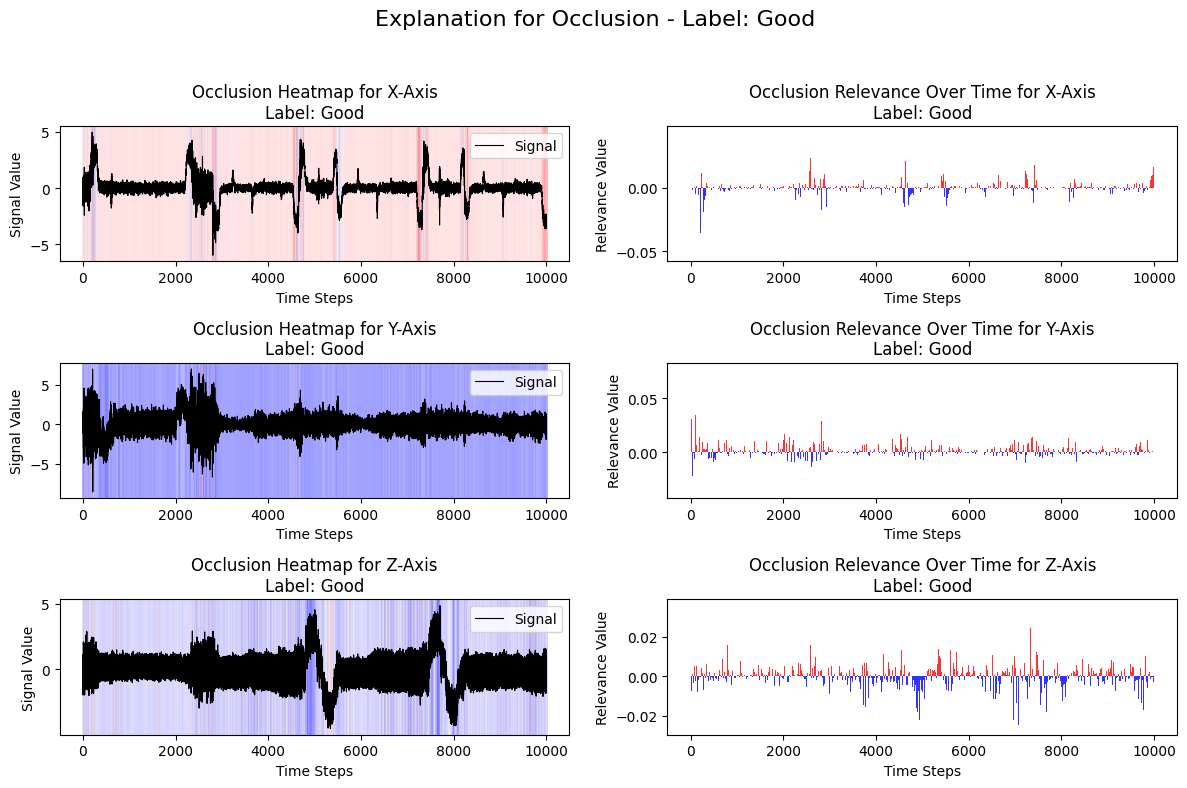

In [44]:
# Assume `sample` is a vibration signal of shape (3, 10000)
# Assume `attributions` are relevance scores from any explanation method
sample, label = next(iter(test_loader))  # Get a test sample

# Example with Integrated Gradients
o_attributions = xai_occlusion_signal(model, sample[0], label[0], occlusion_type='flip')

print(f"Min relevance: {np.min(o_attributions)}, Max relevance: {np.max(o_attributions)}")


# Visualize combined explanations (3x2 grid)
visualize_combined_with_label(sample[0].cpu().numpy(), o_attributions, label[0].item(), "Occlusion")



Min relevance: -0.03726959228515625, Max relevance: 0.02729964256286621


C:\Users\asadi\AppData\Local\Temp\ipykernel_23692\3230944298.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  relevance_colors = plt.cm.get_cmap(cmap)((attributions[i] - np.min(attributions[i])) /


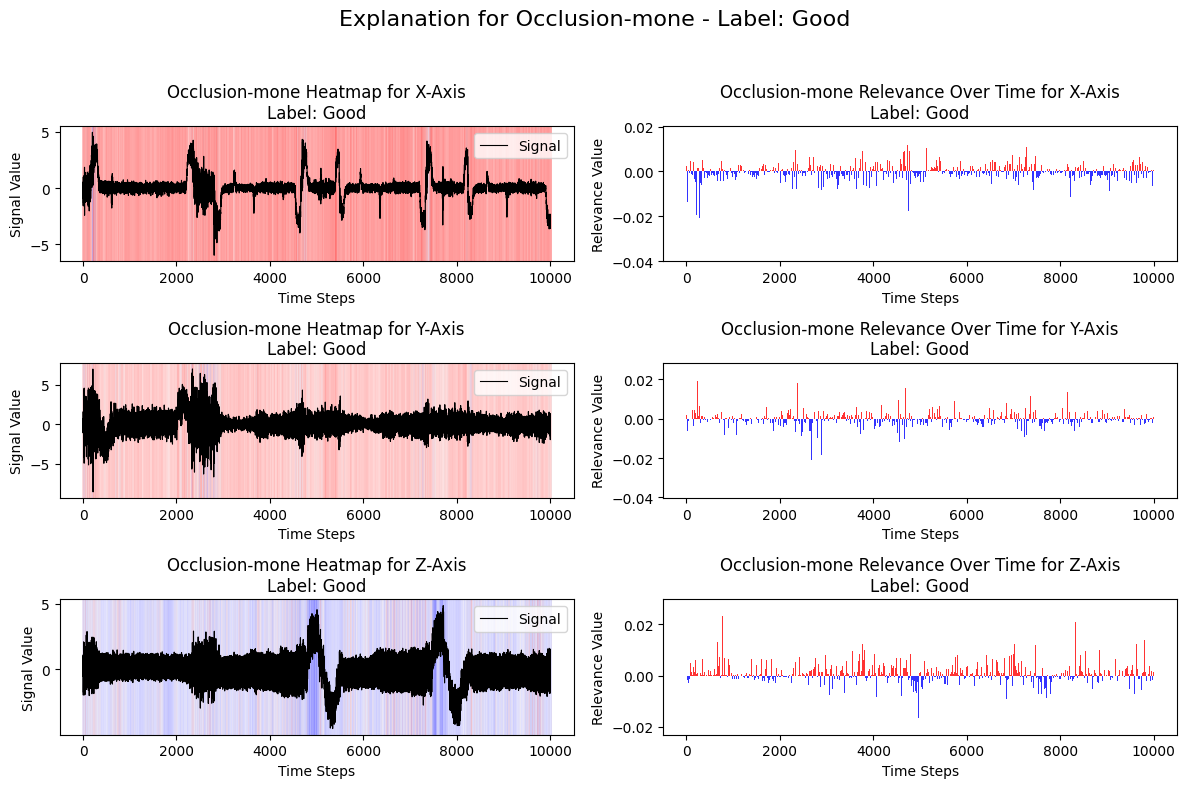

In [47]:
# Assume `sample` is a vibration signal of shape (3, 10000)
# Assume `attributions` are relevance scores from any explanation method
sample, label = next(iter(test_loader))  # Get a test sample

# Example with Integrated Gradients
om_attributions = xai_occlusion_signal(model, sample[0], label[0], occlusion_type='mone')

print(f"Min relevance: {np.min(om_attributions)}, Max relevance: {np.max(om_attributions)}")


# Visualize combined explanations (3x2 grid)
visualize_combined_with_label(sample[0].cpu().numpy(), om_attributions, label[0].item(), "Occlusion-mone")



Min relevance: -0.03660750389099121, Max relevance: 0.03976869583129883


C:\Users\asadi\AppData\Local\Temp\ipykernel_23692\3230944298.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  relevance_colors = plt.cm.get_cmap(cmap)((attributions[i] - np.min(attributions[i])) /


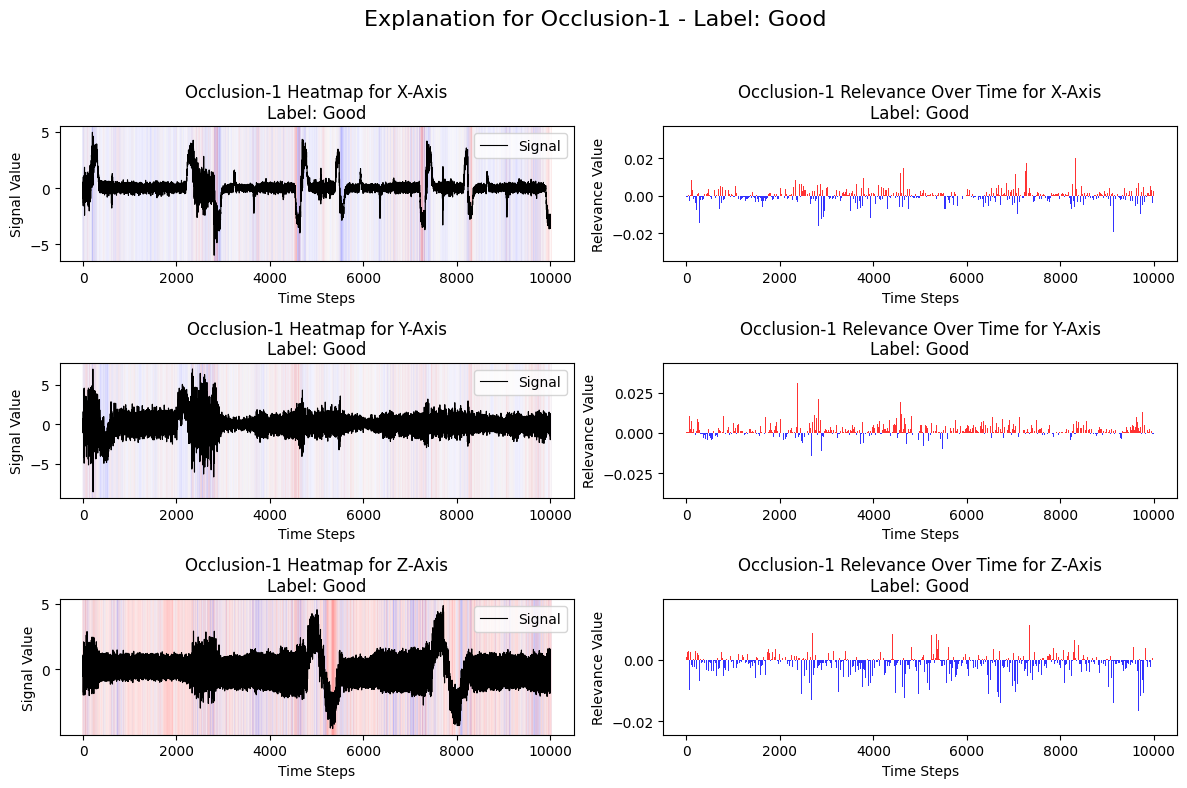

In [45]:
# Example with Integrated Gradients
o1_attributions = xai_occlusion_signal(model, sample[0], label[0], occlusion_type='one')

print(f"Min relevance: {np.min(o1_attributions)}, Max relevance: {np.max(o1_attributions)}")


# Visualize combined explanations (3x2 grid)
visualize_combined_with_label(sample[0].cpu().numpy(), o1_attributions, label[0].item(), "Occlusion-1")

Min relevance: -4.543068854445664e-08, Max relevance: 4.1934097083640154e-08


C:\Users\asadi\AppData\Local\Temp\ipykernel_23692\3230944298.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  relevance_colors = plt.cm.get_cmap(cmap)((attributions[i] - np.min(attributions[i])) /


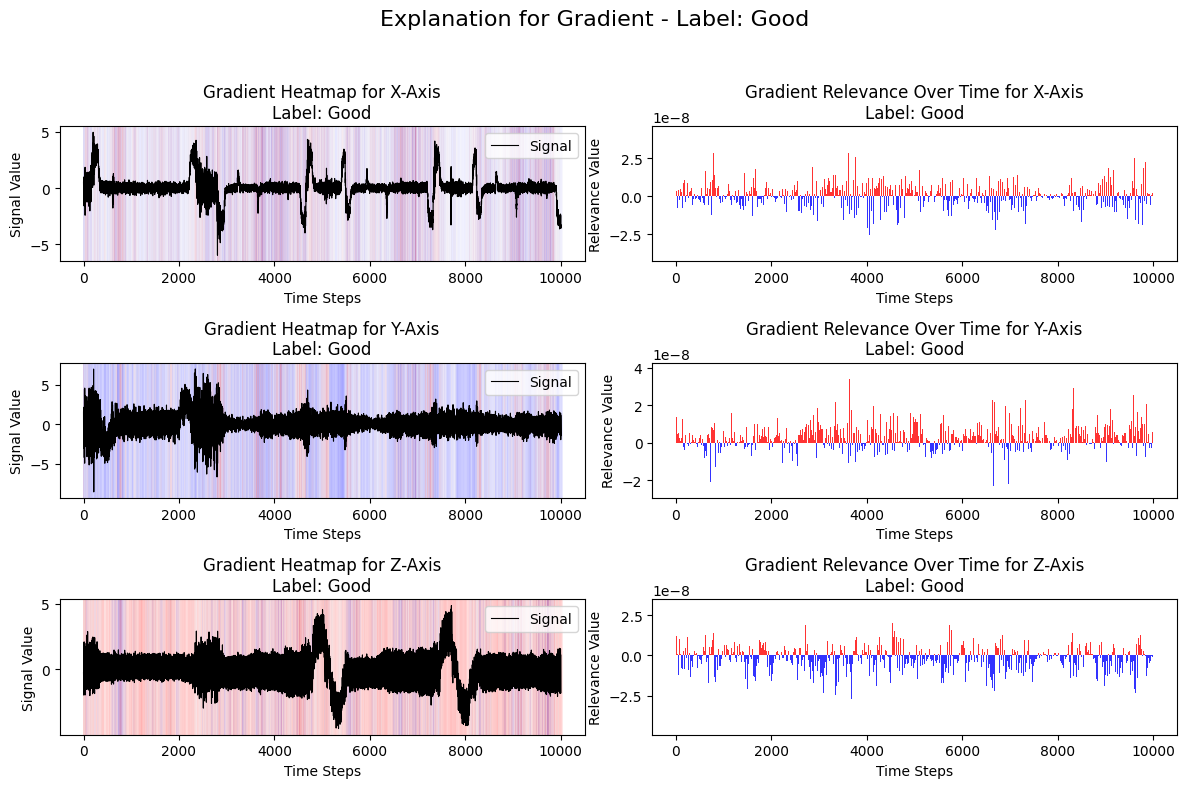

In [46]:
# Example with Integrated Gradients
g_attributions = explain_with_gradients_time_domain(model, sample[0], label[0])

print(f"Min relevance: {np.min(g_attributions)}, Max relevance: {np.max(g_attributions)}")


# Visualize combined explanations (3x2 grid)
visualize_combined_with_label(sample[0].cpu().numpy(), g_attributions, label[0].item(), "Gradient")

Visualizing X-Axis


C:\Users\asadi\AppData\Local\Temp\ipykernel_23692\1787876995.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  relevance_colors = plt.cm.get_cmap(cmap)(0.5 + 0.5 * attributions / np.max(np.abs(attributions)))  # Normalize


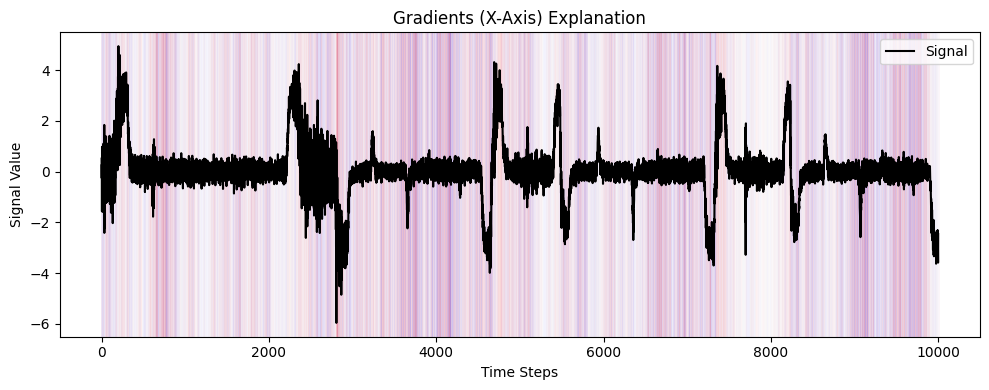

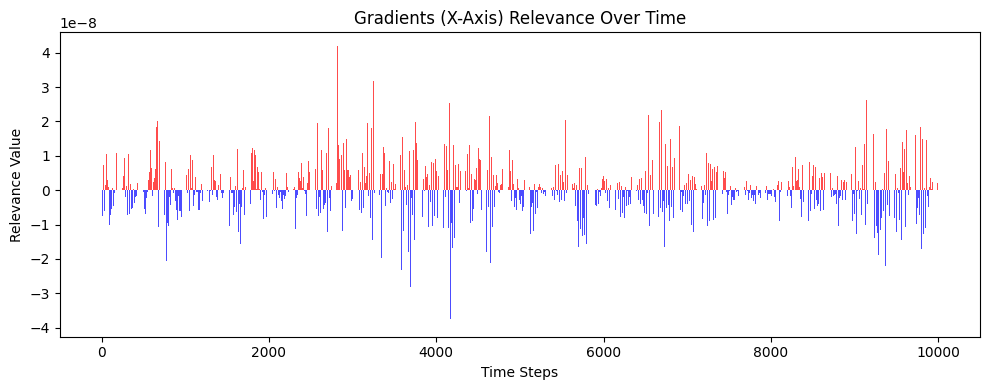

Visualizing Y-Axis


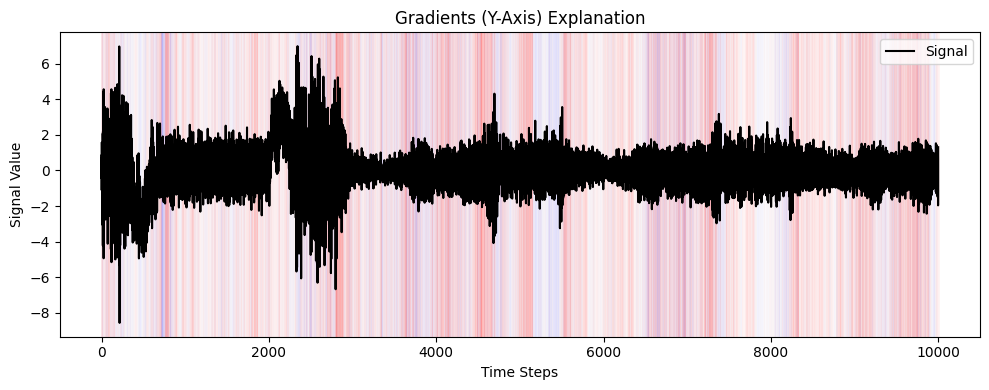

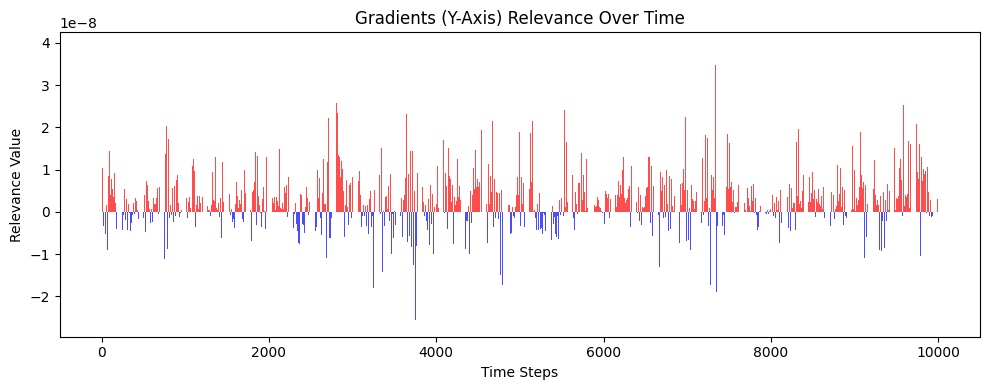

Visualizing Z-Axis


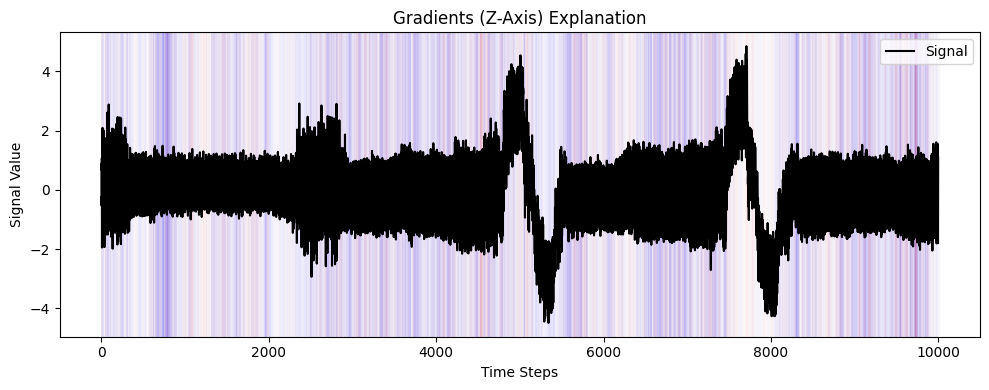

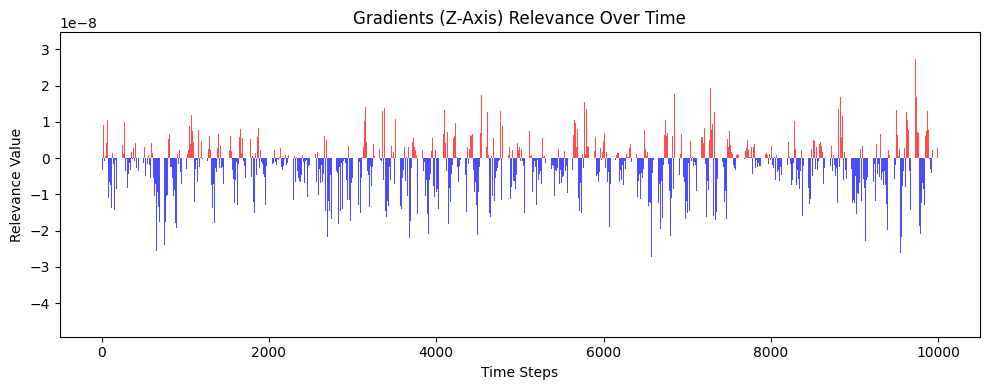

In [34]:
# Assume `sample` is a vibration signal of shape (3, 10000)
# Assume `attributions` are relevance scores from any explanation method
sample, label = next(iter(test_loader))
single_sample = sample[0].to(device)  # Shape: (3, 10000)
single_label = label[0].item()  # Get the integer label (0 or 1)

# Example with Integrated Gradients
gradients = explain_with_gradients_time_domain(model, single_sample, single_label, device=device)

# Visualize full explanation (signal + heatmap + relevance plot)
visualize_full_explanation(sample[0].cpu().numpy(), gradients, "Gradients")


C:\Users\asadi\AppData\Local\Temp\ipykernel_23692\3602577443.py:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color=plt.cm.get_cmap(cmap)((normalized_attr[i][t] + 1) / 2),


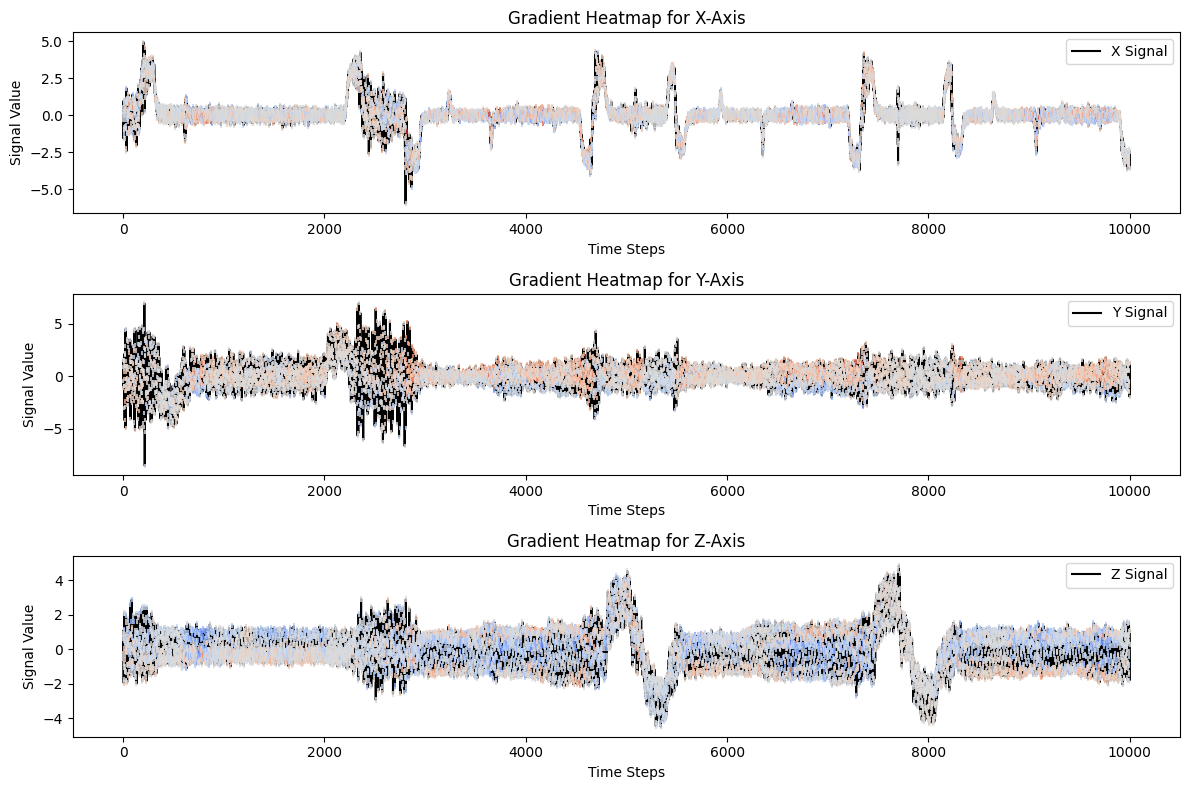

In [25]:
# Load a test sample
# Load a single test sample
# Load a single test sample
sample, label = next(iter(test_loader))
single_sample = sample[0].to(device)  # Shape: (3, 10000)
single_label = label[0].item()  # Get the integer label (0 or 1)

# Compute Gradient Explanation
gradients = explain_with_gradients_time_domain(model, single_sample, single_label, device=device)

# Visualize the 3x3 grid for X, Y, Z axes
signal = single_sample.cpu().numpy()  # Original signal (3, 10000)
visualize_heatmap_attribution(signal, gradients, "Gradient")





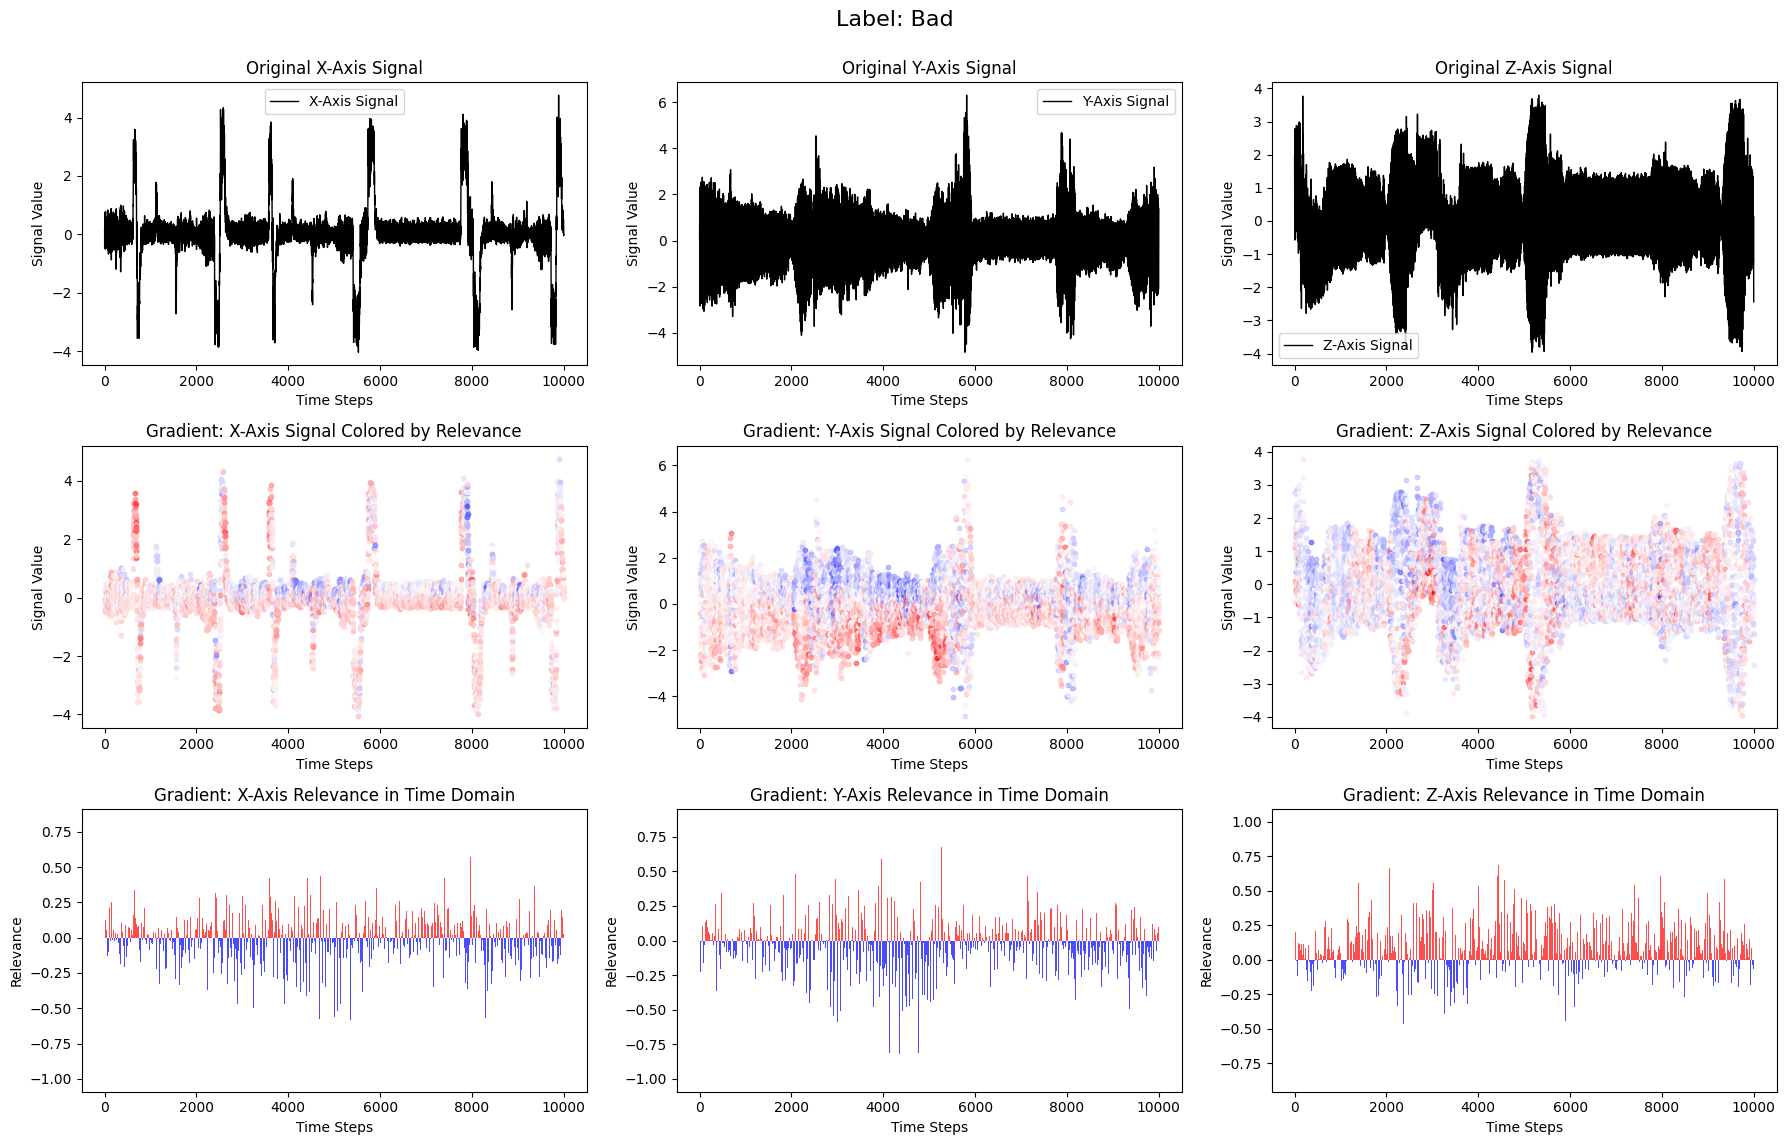

In [85]:
# Find a "bad" sample
for sample, label in test_loader:
    if label[0].item() == 1:  # Check if the label is "bad"
        single_sample = sample[0].to(device)  # Take the first bad sample
        single_label = label[0].item()
        break


# Compute Gradient Explanation
gradients = explain_with_gradients_time_domain(model, single_sample, single_label, device=device)

# Visualize the 3x3 grid for X, Y, Z axes
signal = single_sample.cpu().numpy()  # Original signal (3, 10000)
visualize_signal_relevance_grid_improved(signal, gradients, "Gradient", single_label, normalize=True)

C:\Users\asadi\AppData\Local\Temp\ipykernel_7288\1927296863.py:12: RuntimeWarning: invalid value encountered in divide
  attributions[i] = attributions[i] / np.max(np.abs(attributions[i]))


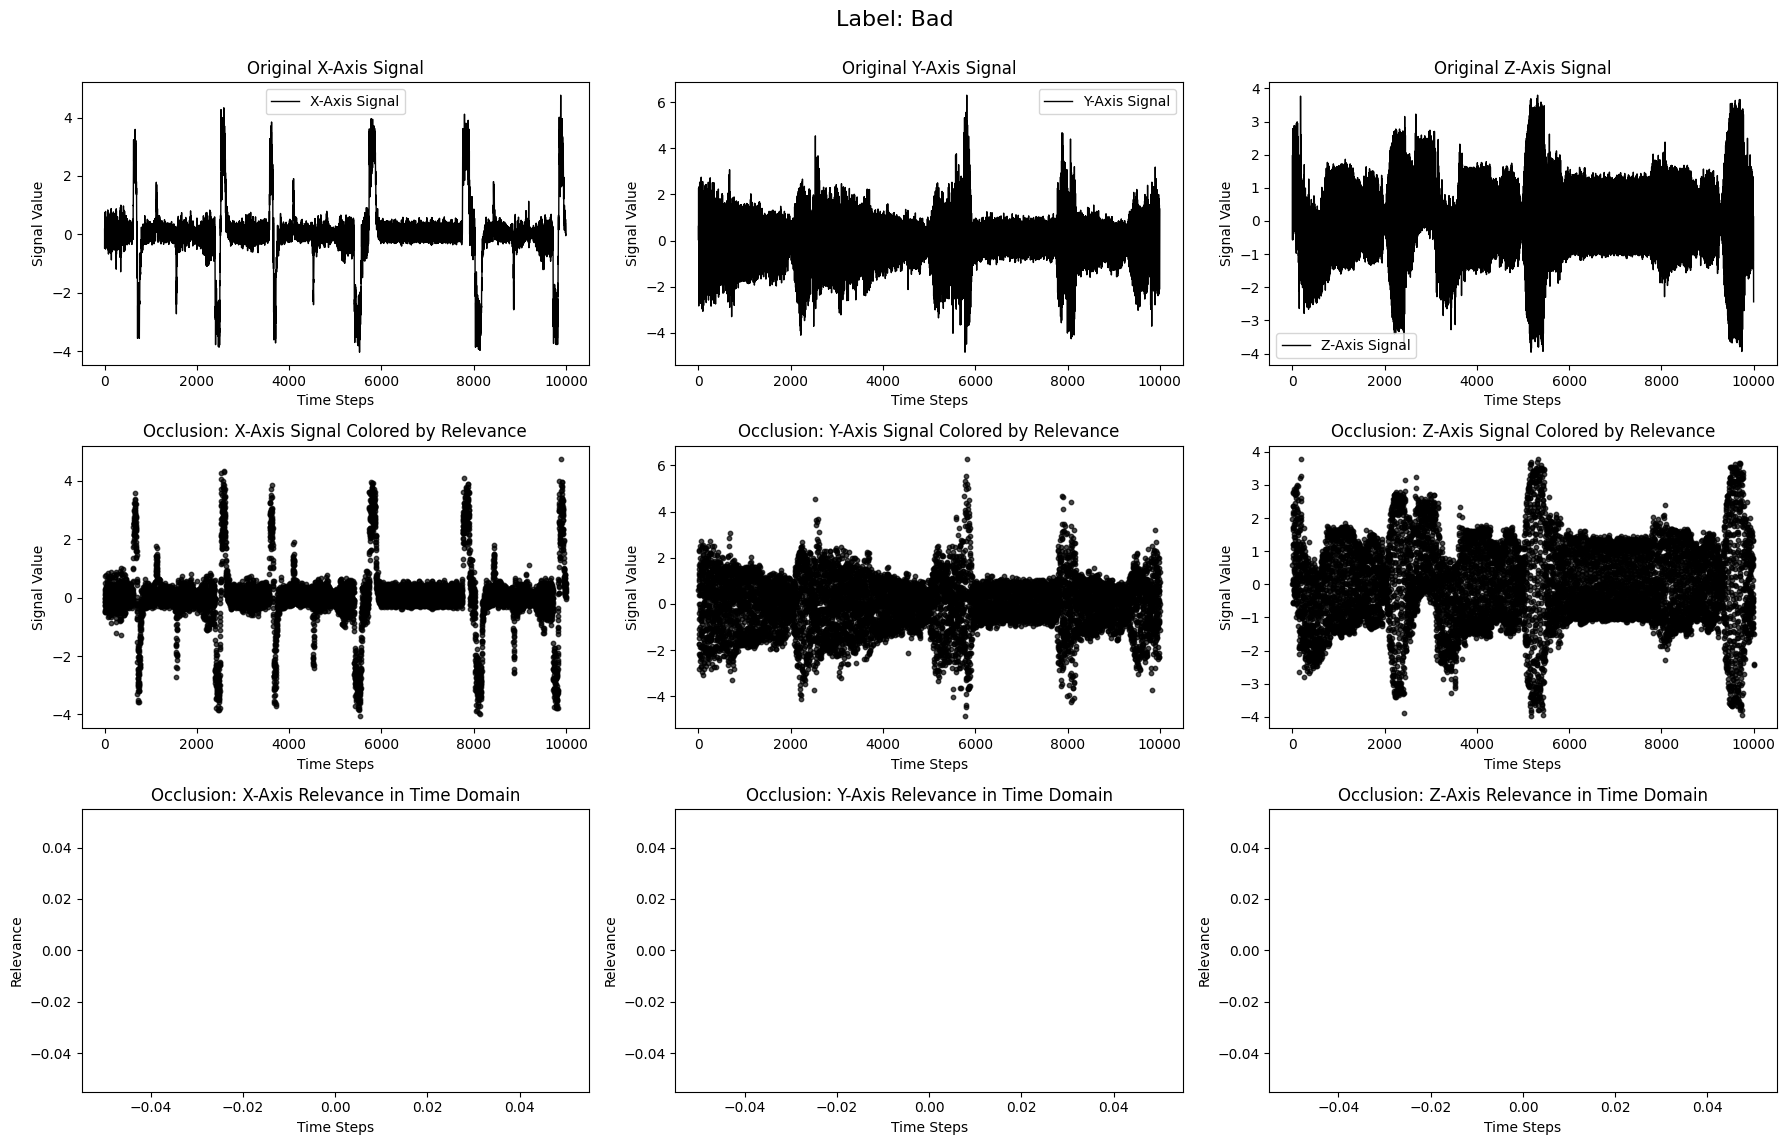

In [87]:
# Load a "bad" test sample
for sample, label in test_loader:
    if label[0].item() == 1:  # Check if the label is "bad"
        single_sample = sample[0].to(device)  # Take the first bad sample
        single_label = label[0].item()
        break

# Compute Gradient Explanation
occlusions = occlusion_sensitivity_time_domain(model, single_sample, single_label, device=device)

# Visualize the 3x3 grid for X, Y, Z axes
signal = single_sample.cpu().numpy()  # Original signal (3, 10000)
visualize_signal_relevance_grid_improved(signal, occlusions, "Occlusion", single_label, normalize=True)





Visualizing ZERO occlusion...


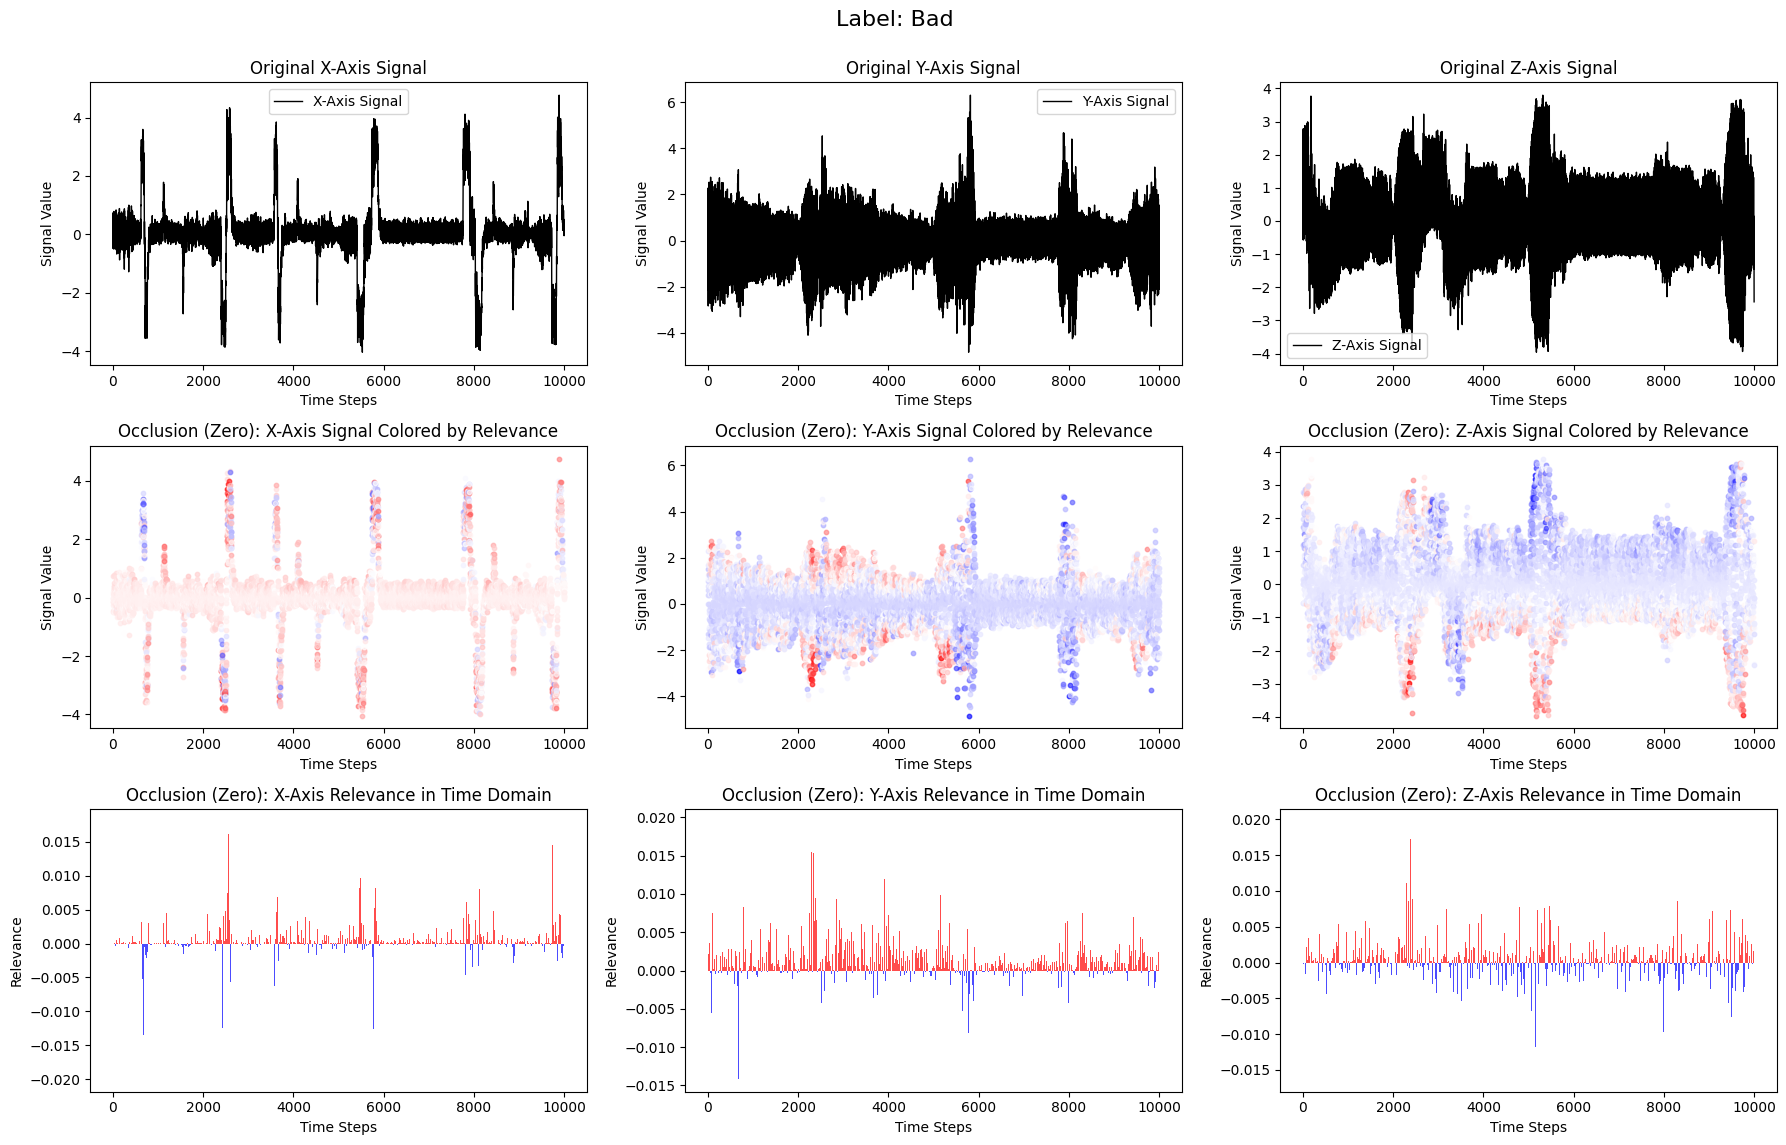

Visualizing ONE occlusion...


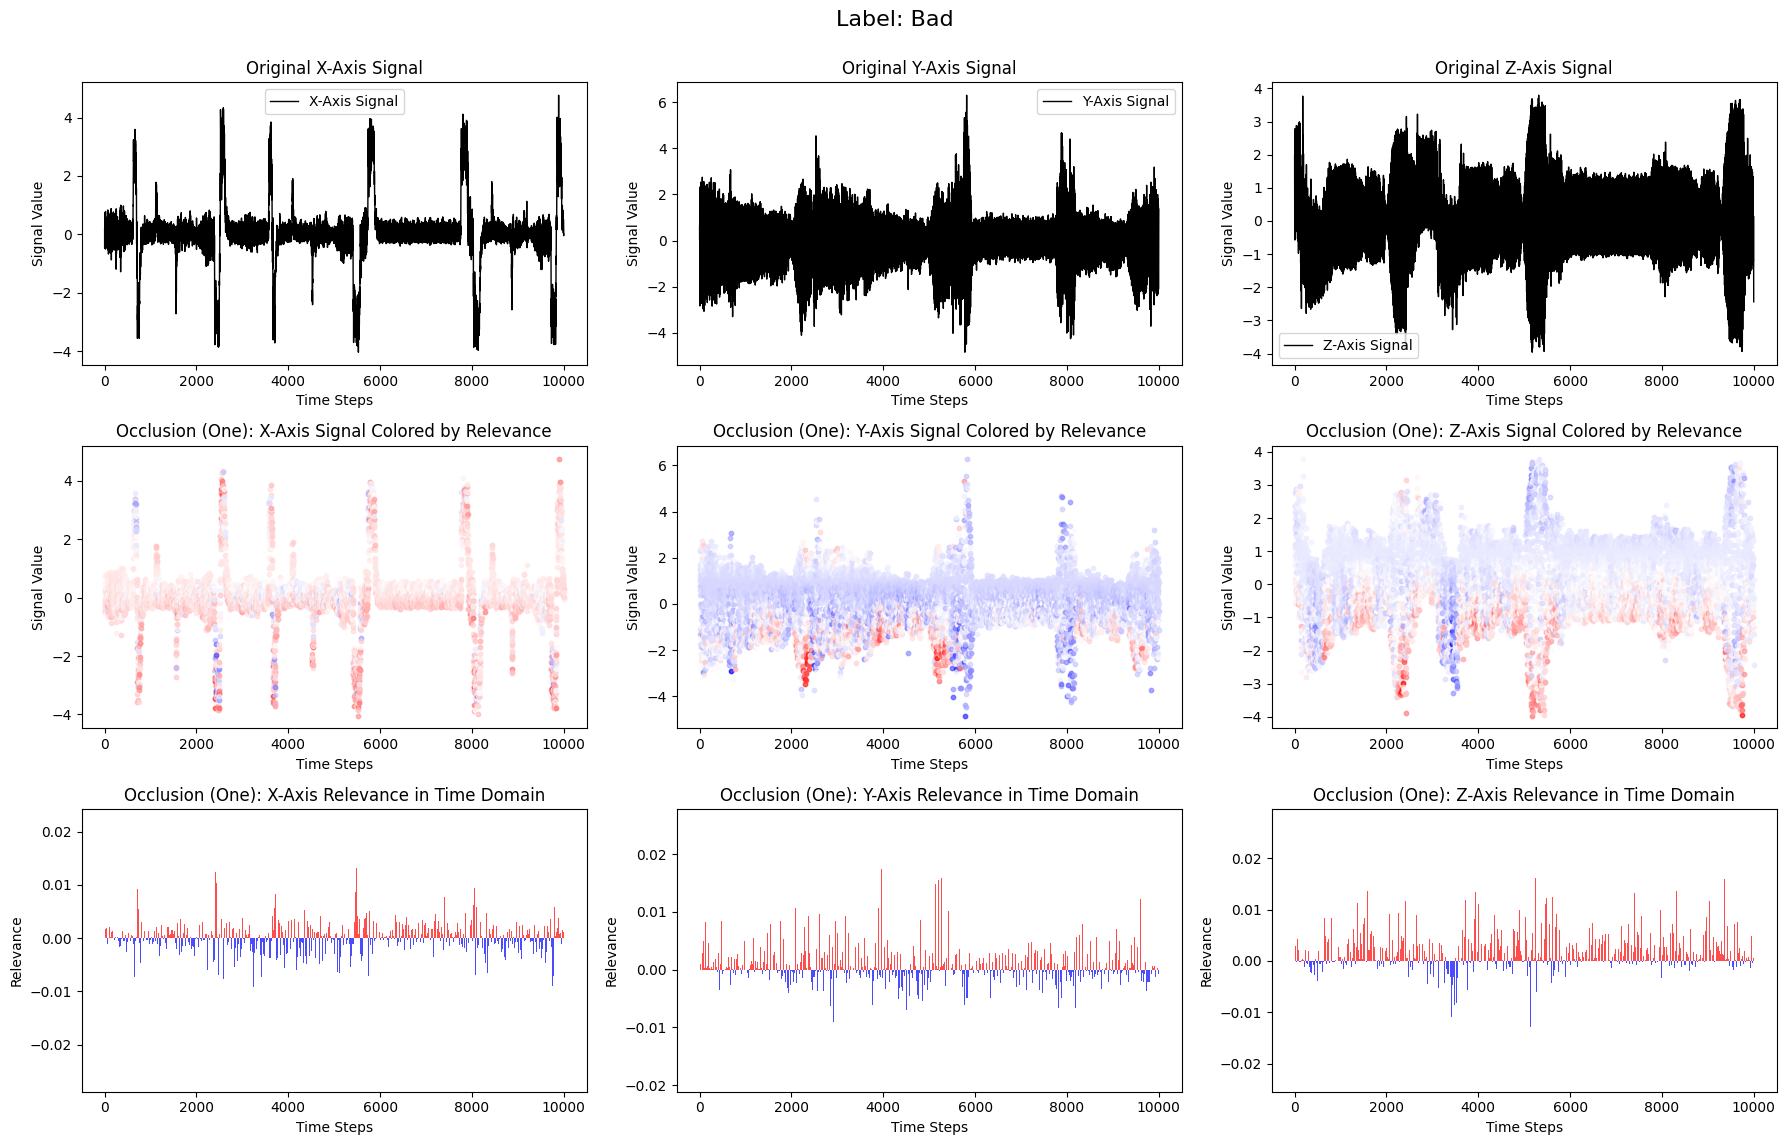

Visualizing MONE occlusion...


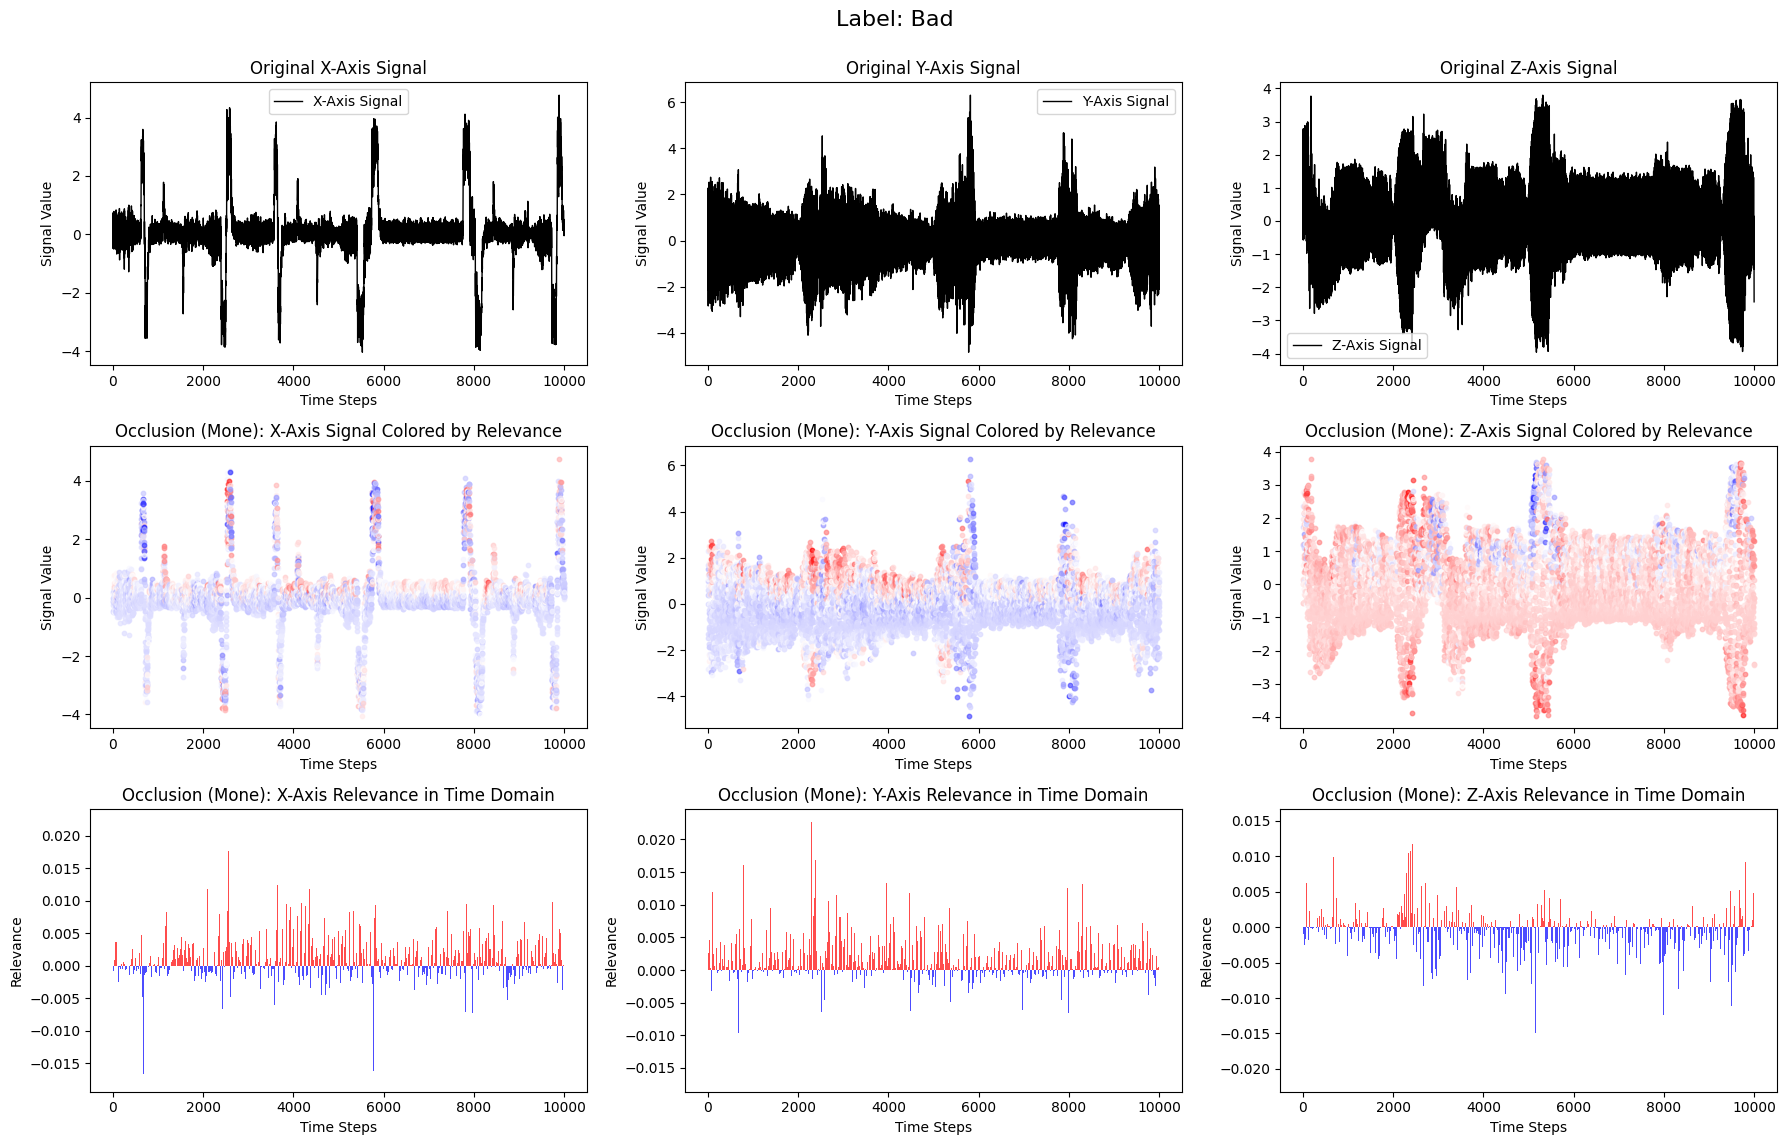

Visualizing FLIP occlusion...


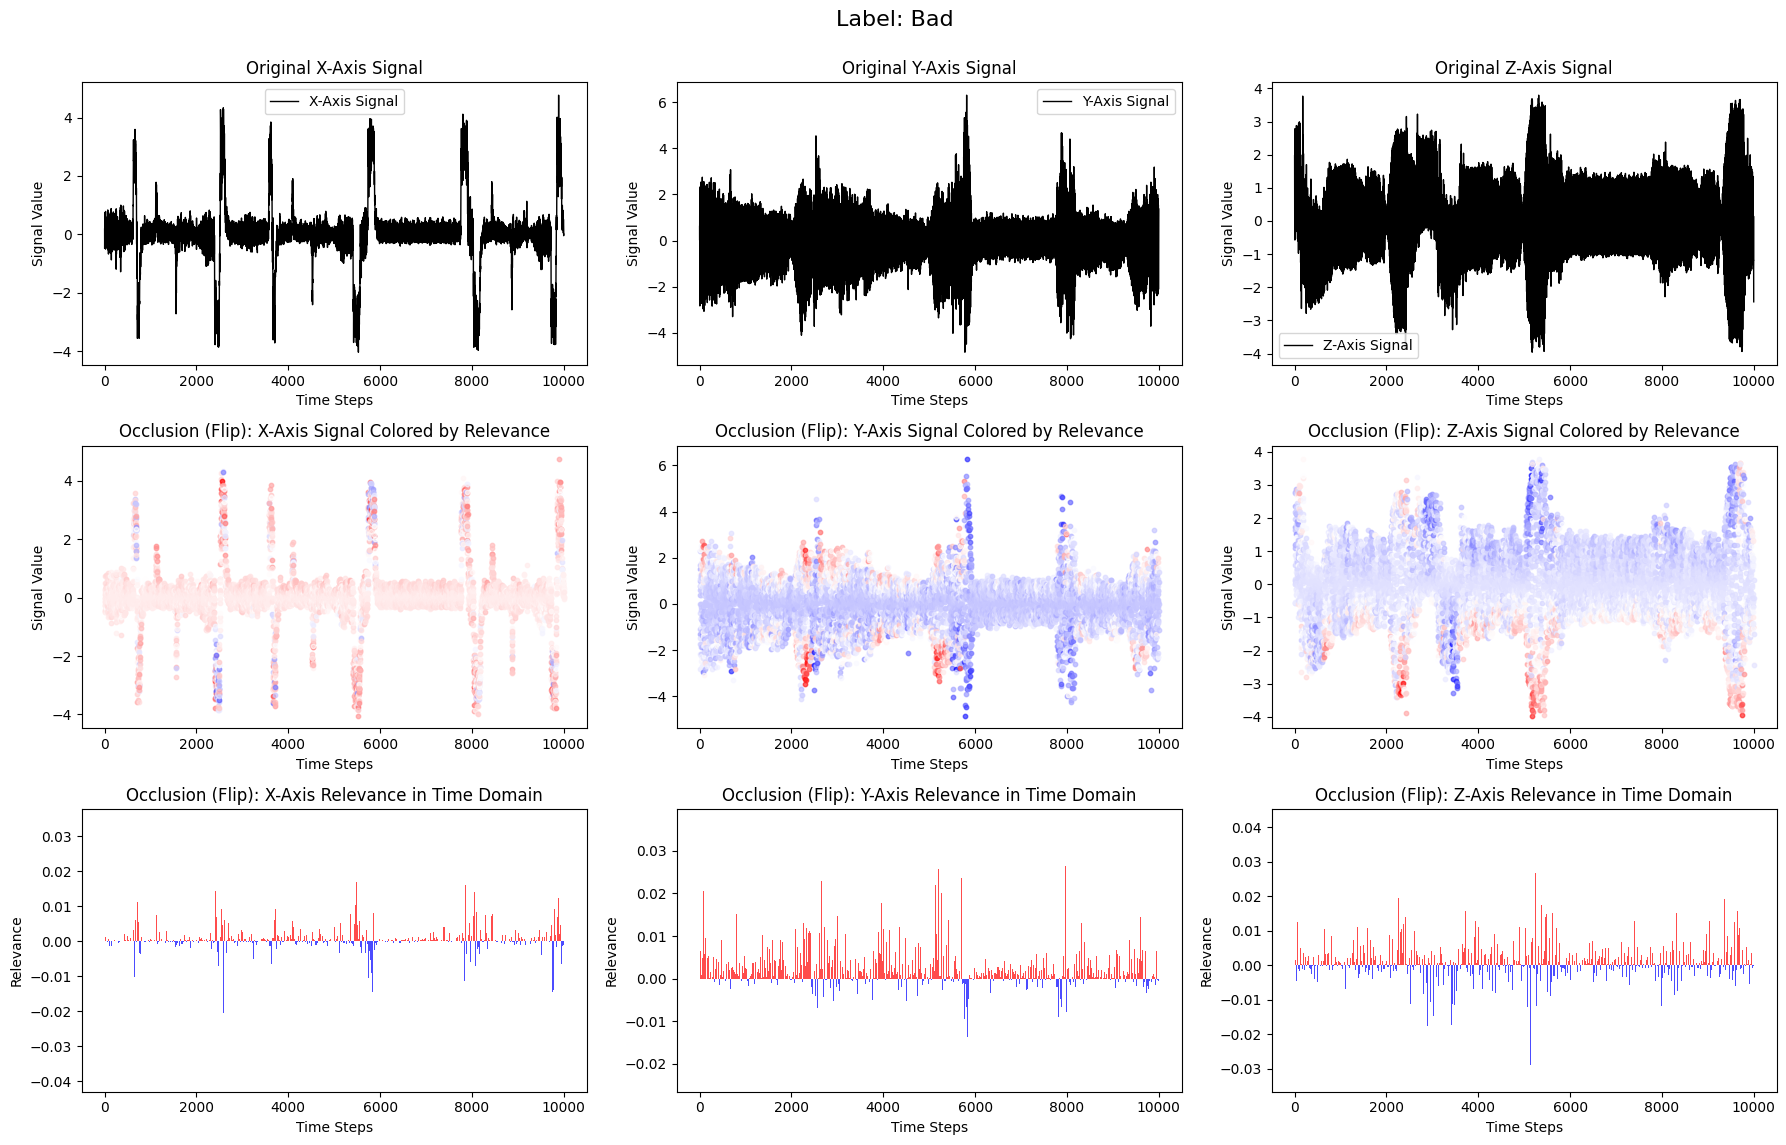

In [90]:
# Define occlusion types
occlusion_types = ["zero", "one", "mone", "flip"]

# Load a "bad" test sample
for sample, label in test_loader:
    if label[0].item() == 1:  # Check if the label is "bad"
        single_sample = sample[0].to(device)  # Take the first bad sample
        single_label = label[0].item()
        break

# Iterate through occlusion types
for occlusion_type in occlusion_types:
    print(f"Visualizing {occlusion_type.upper()} occlusion...")
    occlusion_attributions = xai_occlusion_signal(model, single_sample, single_label, occlusion_type, device=device)

    # Visualize the relevance for all axes (X, Y, Z)
    visualize_signal_relevance_grid_improved(
        single_sample.cpu().numpy(), occlusion_attributions, f"Occlusion ({occlusion_type.capitalize()})", single_label
    )
